In [87]:
# %%writefile Ind_RVI_OSC.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class RVI(Ind_Model_Base.Ind_Model):
    """相对活力指数RVI (Relative Vigor Index)
    """
    optimum_param={'valid':False, 'main':'RVI', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'RVI', frequence)
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':20}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['RVIsignal'] - item_df['ma10'])
#             return -1 * np.abs( af.timeline_event_continuity(direct.fillna(0)) )
            return af.timeline_event_continuity(direct.fillna(0))

        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_RVI_CONTINUITY']))
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return event_continuity
        
    def kernel(self,dataframe, timeperiod):
        
        if len(dataframe)<=timeperiod:
            return None
        
        close = dataframe.close
        open = dataframe.open
        high = dataframe.high
        low = dataframe.low
        X = close-open+2*(close.shift()-open.shift())+2*(close.shift(2)-open.shift(2))*(close.shift(3)-open.shift(3)) / 6
        Y = high-low+2*(high.shift()-low.shift())+2*(high.shift(2)-low.shift(2))*(high.shift(3)-low.shift(3)) / 6
        Z = talib.MA(X, timeperiod=10)*10
        D = talib.MA(Y, timeperiod=10)*10
        RVI = Z/D
        RVI.name = 'RVI'
        RVIsignal = (RVI + 2 * RVI.shift() + 2 * RVI.shift(2) + RVI.shift(3))/6
        RVIsignal.name = 'RVIsignal'

        ma10 = talib.MA(RVI,10)
        
        ma10.name = 'ma10'
        
        df = pd.concat([RVI,RVIsignal,ma10], axis=1)
#         df = pd.DataFrame(RVI)
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


Wall time: 117 ms


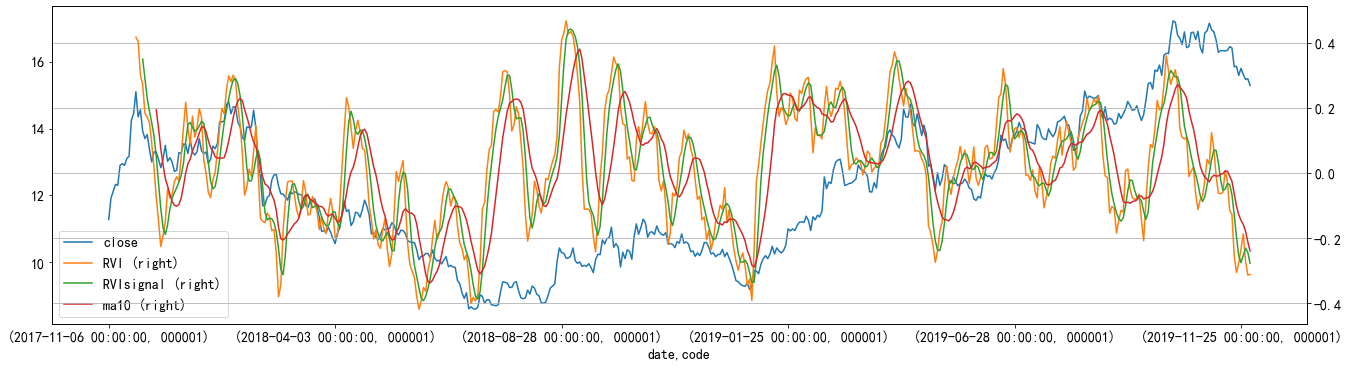

In [76]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
data = smpl.get_data(['000001'],end='2019-11-29',gap=504).data

rvi =RVI(data)
rvi.fit()
pd.concat([data.close,rvi.ind_df['RVI'],rvi.ind_df['RVIsignal'],rvi.ind_df['ma10']],axis=1).plot(secondary_y=['RVI','RVIsignal','ma10'],figsize=(1620/72,420/72))
plt.grid()
# rvi.ind_df

# diff = data.close[0:10]
# np.where(np.sign(diff)>=0,diff,0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


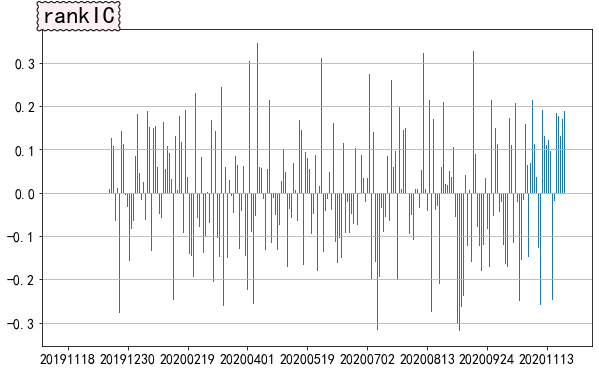

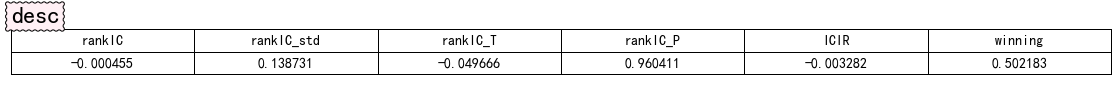

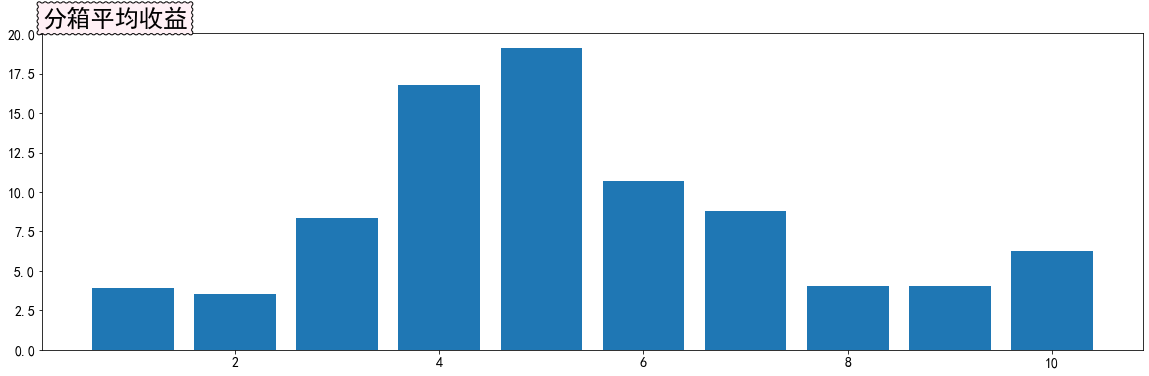

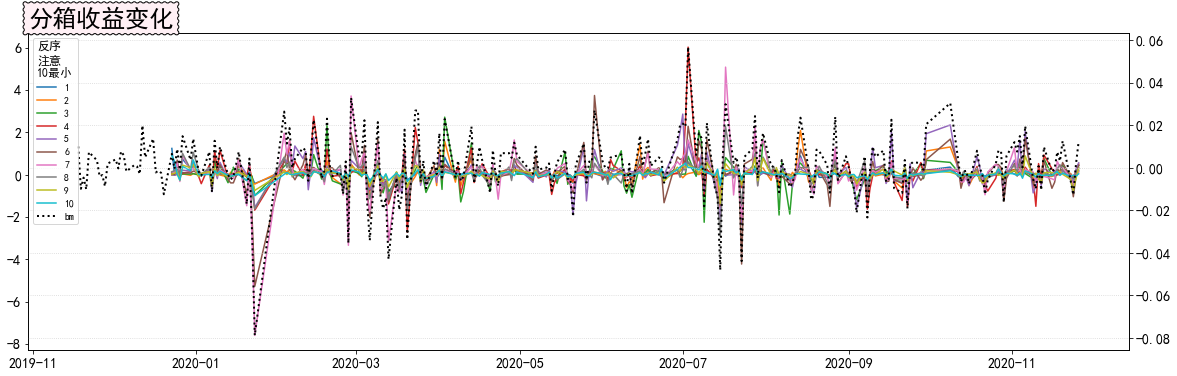

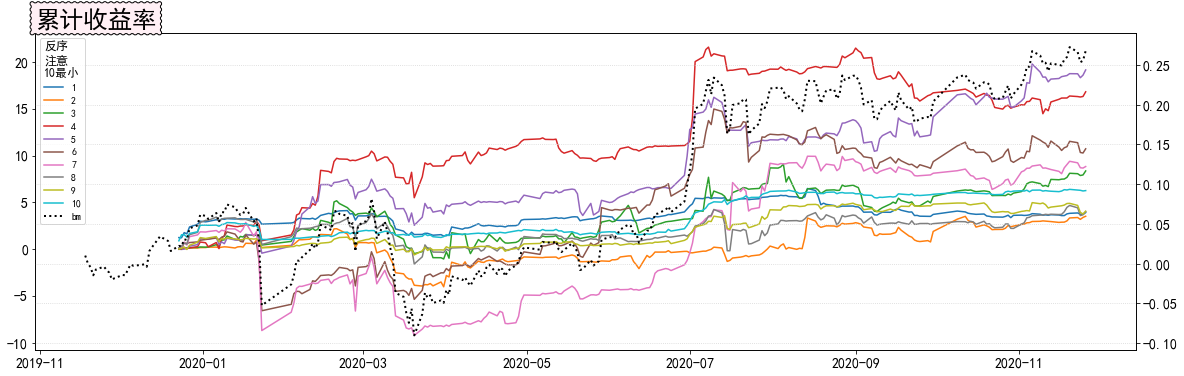

Wall time: 12.6 s


In [86]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

test = FactorTest(RVI, sample='沪深300', freq="d",end='2020-11-28',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='feature_RVI_CONTINUITY')
test.process()
test.plot()


In [39]:
pd.Series([1,2,3,4,5]).shift()

0    NaN
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64